# ENEL 645 Project: Automated Object Classification in Images with Machine Learning
## Adam Kerr (10146363)

In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO   
import os

import math

import glob
import pandas as pd
import xml.etree.ElementTree as ET

import tensorflow as tf
import keras

from sklearn.metrics import confusion_matrix
import seaborn as sn

Using TensorFlow backend.


### Set up directory paths

In [2]:
root_path = 'C:/Users/Adam/Desktop/School/ENEL645'
data_path = root_path + '/DIOR'
train_path = data_path + '/trainval'
test_path = data_path + '/test'
annotation_path = data_path + '/Annotations'
train_annotation_path = annotation_path + '/trainval'
test_annotation_path = annotation_path + '/test'
additional_data_path = data_path = root_path + '/D2'
additional_images_path = additional_data_path + '/Images'
additional_annotations_path = additional_data_path + '/Annotations'

## I. Classification of Cropped Annotations using Xception

### Function for reading annotations into dataframe

In [3]:
def xml_to_df(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines them in a single Pandas datagrame.

    Parameters:
    ----------
    path : {str}
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """
    classlist = ['ship','vehicle','airplane']
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            #print(member.find('bndbox')[0].text)  #we get ymin xmin ymax x min
            if any (x in member.find('name').text for x in classlist):
            #member[0] is name..but thats only if the name is directly under <object>
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        member.find('name').text,
                        int(member.find('bndbox')[0].text),
                        int(member.find('bndbox')[1].text),
                        int(member.find('bndbox')[2].text),
                        int(member.find('bndbox')[3].text)
                        )
                xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

### Read training annotations

In [4]:
try:
    train_annot_df = pd.read_csv('train_annotations.csv') 
except:
    train_annot_df = xml_to_df(train_annotation_path)
    train_annot_df.to_csv('train_annotations.csv')
    
train_annot_df = train_annot_df.iloc[:,1:]
train_annot_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,00002.jpg,800,800,vehicle,49,231,67,242
1,00002.jpg,800,800,vehicle,54,252,72,262
2,00002.jpg,800,800,vehicle,297,227,316,239
3,00005.jpg,800,800,vehicle,188,245,201,265
4,00005.jpg,800,800,vehicle,1,679,32,695
...,...,...,...,...,...,...,...,...
42894,11721.jpg,800,800,ship,660,636,681,696
42895,11725.jpg,800,800,vehicle,264,424,276,441
42896,11725.jpg,800,800,vehicle,288,440,305,456
42897,11725.jpg,800,800,vehicle,590,486,602,500


### Read testing annotations

In [5]:
try:
    test_annot_df = pd.read_csv('test_annotations.csv') 
except:
    test_annot_df = xml_to_df(test_annotation_path)
    test_annot_df.to_csv('test_annotations.csv')
    
test_annot_df = test_annot_df.iloc[:,1:]
test_annot_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,11726.jpg,800,800,airplane,256,131,318,189
1,11726.jpg,800,800,airplane,254,203,302,263
2,11726.jpg,800,800,airplane,225,253,325,333
3,11726.jpg,800,800,airplane,276,296,341,365
4,11726.jpg,800,800,airplane,265,345,321,392
...,...,...,...,...,...,...,...,...
69970,23462.jpg,800,800,vehicle,45,392,91,421
69971,23462.jpg,800,800,vehicle,39,169,254,272
69972,23463.jpg,800,800,vehicle,148,311,187,337
69973,23463.jpg,800,800,vehicle,467,492,514,518


### Determine average sizes of annotations

In [6]:
total_dx = 0
total_dy = 0

for index, row in train_annot_df.iterrows():
    total_dx += row['xmax'] - row['xmin']
    total_dy += row['ymax'] - row['ymin']
    
n = train_annot_df.shape[0]

avg_width = total_dx / n
avg_height = total_dy / n

print('Average width: %f' % avg_width)
print('Average height: %f' % avg_height)

Average width: 42.068650
Average height: 42.583650


### Crop annotations and resize to model input

In [7]:
label_map = {'airplane' : 0, 'ship': 1, 'vehicle': 2}

def get_images_and_labels(mode):
    if mode == 'train':
        path = train_path
        df = train_annot_df
    elif mode == 'test':
        path = test_path
        df = test_annot_df
    elif mode == 'extra':
        path = additional_images_path
        df = extra_annot_df
    
    
    input_dim = 42
    
    images = []
    labels = []
        
    for index, row in df.iterrows():
        imagefile = path + '/' + row['filename']
        image = Image.open( imagefile ).crop((row['xmin'], row['ymin'], row['xmax'], row['ymax'])).resize((input_dim, input_dim))
        b = BytesIO()
        image.save(b,format="jpeg")
        image = Image.open(b)
        image = np.asarray( image ) / 255.0
        images.append( image )
        label = np.zeros(3)
        label[label_map[row['class']]] = 1
        labels.append(label)

    images = np.asarray(images)
    labels = np.asarray(labels)
        
    return images, labels

### Get training data

In [8]:
train_images, train_labels = get_images_and_labels('train')

In [9]:
from keras import Model, Input
from keras.layers import Dense, Dropout, Flatten

### Import Xception pre-trained model, add new output layer and compile

In [34]:
from keras.applications.xception import Xception

input_tensor = Input(shape=(42,42,3))

model = Xception(include_top=False, input_tensor=input_tensor)

x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.75)(x)
predictions = Dense(3, activation="softmax")(x)

xception = Model(input = model.input, output = predictions)
          
xception.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#xception.summary()

C:\Users\Adam\Envs\ENEL645\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


### Train model

In [35]:
history = xception.fit(train_images, train_labels, batch_size=1024, epochs=8)

Epoch 1/8
42899/42899 [==============================] - 28s 652us/step - loss: 0.2938 - acc: 0.8454
Epoch 2/8
42899/42899 [==============================] - 19s 451us/step - loss: 0.0394 - acc: 0.9879
Epoch 3/8
42899/42899 [==============================] - 19s 452us/step - loss: 0.0156 - acc: 0.9948
Epoch 4/8
42899/42899 [==============================] - 20s 455us/step - loss: 0.0133 - acc: 0.9956
Epoch 5/8
42899/42899 [==============================] - 19s 453us/step - loss: 0.0097 - acc: 0.9967
Epoch 6/8
42899/42899 [==============================] - 19s 452us/step - loss: 0.0096 - acc: 0.9972
Epoch 7/8
42899/42899 [==============================] - 19s 452us/step - loss: 0.0083 - acc: 0.9972
Epoch 8/8
42899/42899 [==============================] - 19s 452us/step - loss: 0.0073 - acc: 0.9977


### Display training history

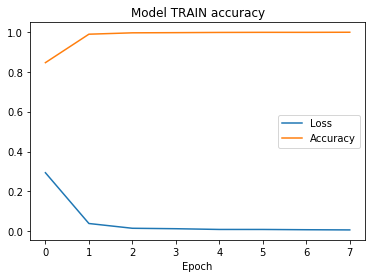

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('Model TRAIN accuracy')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='right')
plt.show()

### Get testing data

In [13]:
test_images, test_labels = get_images_and_labels('test')

### Evaluate on test images

In [37]:
test_loss, test_acc = xception.evaluate(test_images,  test_labels, verbose=2)
print('\nTest loss:', test_loss)  
print('\nTest accuracy: %f %%' % (test_acc * 100))


Test loss: 0.5784793875985108

Test accuracy: 94.060736 %


### Output confusion matrix

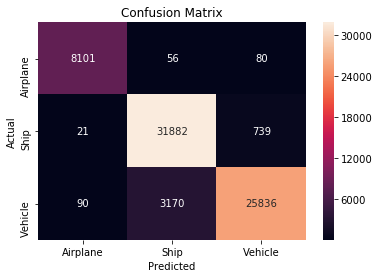

In [38]:
pred = xception.predict(test_images)

predictions = np.array([np.argmax(x) for x in pred])
labels = np.array([np.argmax(x) for x in test_labels])

fig, ax = plt.subplots()
cm = confusion_matrix(predictions, labels)
df_cm = pd.DataFrame(cm, ['Airplane', 'Ship', 'Vehicle'], ['Airplane', 'Ship', 'Vehicle'])
sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_ylim(3.0,0.0)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Read additional annotations

In [16]:
try:
    extra_annot_df = pd.read_csv('extra_annotations.csv') 
except:
    extra_annot_df = xml_to_df(additional_annotations_path)
    extra_annot_df.to_csv('extra_annotations.csv')
    
extra_annot_df = extra_annot_df.iloc[:,1:]
extra_annot_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1.jpg,300,304,airplane,48,95,94,132
1,1.jpg,300,304,airplane,179,158,223,206
2,1.jpg,300,304,airplane,108,158,149,192
3,1.jpg,300,304,airplane,93,126,135,157
4,1.jpg,300,304,airplane,69,161,111,195
...,...,...,...,...,...,...,...,...
188,8.jpg,463,284,airplane,363,58,452,168
189,9.jpg,348,194,airplane,61,221,105,262
190,9.jpg,348,194,airplane,35,15,149,139
191,9.jpg,348,194,airplane,143,7,221,89


### Get additional data

In [17]:
extra_images, extra_labels = get_images_and_labels('extra')

### Evaluate on additional images 

In [39]:
test_loss, test_acc = xception.evaluate(extra_images,  extra_labels, verbose=2)
print('\nTest loss:', test_loss)  
print('\nTest accuracy: %f %%' % (test_acc * 100))


Test loss: 0.05898539698808554

Test accuracy: 97.927461 %


### Output confusion matrix for additional data

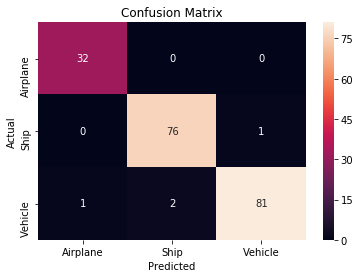

In [40]:
pred = xception.predict(extra_images)

predictions = np.array([np.argmax(x) for x in pred])
labels = np.array([np.argmax(x) for x in extra_labels])

fig, ax = plt.subplots()
cm = confusion_matrix(predictions, labels)
df_cm = pd.DataFrame(cm, ['Airplane', 'Ship', 'Vehicle'], ['Airplane', 'Ship', 'Vehicle'])
sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_ylim(3.0,0.0)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## II. Object Detection and Classification using YOLOv3

The YOLOv3 model was trained using the provided script _train.py_. The prediction script _predict.py_ was slightly modified to save the prediction data into a .csv file.

### Read predictions

In [20]:
predictions_df = pd.read_csv('predictions.csv')
predictions_df = predictions_df.iloc[:,1:]
predictions_df

,filename,class,xmin,ymin,xmax,ymax
0,11726.jpg,airplane,238,219,322,366
1,11726.jpg,airplane,493,307,543,352
2,11726.jpg,airplane,250,418,327,497
3,11726.jpg,airplane,499,481,579,573
4,11726.jpg,airplane,247,527,323,613
...,...,...,...,...,...,...
46193,23462.jpg,vehicle,358,74,386,126
46194,23462.jpg,vehicle,286,135,306,178
46195,23463.jpg,vehicle,153,311,184,336
46196,23463.jpg,vehicle,466,486,513,518


### Get actual class counts for each image

In [21]:
test_counts = test_annot_df.groupby(['filename', 'class']).agg('count')
test_counts = test_counts.loc[:, 'width'].to_frame()
test_counts = test_counts.rename(columns={'width': 'count'})
test_counts = test_counts.pivot_table(
                        values='count', 
                        index=['filename'], 
                        columns='class', 
                        aggfunc=np.sum).fillna(0)
test_counts.columns = pd.MultiIndex.from_tuples([('actual', 'airplane'),('actual', 'ship'),('actual', 'vehicle')])
test_counts

actual             
          airplane ship vehicle
filename                       
11726.jpg     25.0  0.0     6.0
11728.jpg      0.0  1.0     0.0
11736.jpg     13.0  0.0     0.0
11737.jpg     11.0  0.0     0.0
11738.jpg      0.0  0.0     5.0
...            ...  ...     ...
23459.jpg      0.0  0.0     3.0
23460.jpg      0.0  0.0     1.0
23461.jpg      0.0  0.0     3.0
23462.jpg      0.0  0.0     7.0
23463.jpg      0.0  0.0     3.0

[4824 rows x 3 columns]

### Get predicted class counts for each image

In [22]:
pred_counts = predictions_df.groupby(['filename', 'class']).agg('count')
pred_counts = pred_counts.loc[:, 'xmin'].to_frame()
pred_counts = pred_counts.rename(columns={'xmin': 'count'})
pred_counts = pred_counts.pivot_table(
                        values='count', 
                        index=['filename'], 
                        columns='class', 
                        aggfunc=np.sum).fillna(0)
pred_counts.columns = pd.MultiIndex.from_tuples([('predicted', 'airplane'),('predicted', 'ship'),('predicted', 'vehicle')])
pred_counts

predicted             
           airplane ship vehicle
filename                        
11726.jpg       8.0  0.0     0.0
11728.jpg       0.0  1.0     1.0
11734.jpg       0.0  0.0     1.0
11737.jpg       0.0  0.0     1.0
11738.jpg       0.0  0.0     2.0
...             ...  ...     ...
23459.jpg       0.0  0.0     4.0
23460.jpg       0.0  0.0     1.0
23461.jpg       0.0  0.0     6.0
23462.jpg       0.0  0.0     6.0
23463.jpg       0.0  0.0     3.0

[4532 rows x 3 columns]

### Join dataframes

In [23]:
merged_df = pd.merge(test_counts, pred_counts, on='filename', how='outer').fillna(0)
merged_df

actual              predicted             
          airplane ship vehicle  airplane ship vehicle
filename                                              
11726.jpg     25.0  0.0     6.0       8.0  0.0     0.0
11728.jpg      0.0  1.0     0.0       0.0  1.0     1.0
11736.jpg     13.0  0.0     0.0       0.0  0.0     0.0
11737.jpg     11.0  0.0     0.0       0.0  0.0     1.0
11738.jpg      0.0  0.0     5.0       0.0  0.0     2.0
...            ...  ...     ...       ...  ...     ...
23400.jpg      0.0  0.0     0.0       0.0  0.0     1.0
23430.jpg      0.0  0.0     0.0       0.0  0.0     1.0
23433.jpg      0.0  0.0     0.0       0.0  0.0     1.0
23437.jpg      0.0  0.0     0.0       0.0  0.0     1.0
23451.jpg      0.0  0.0     0.0       0.0  2.0     0.0

[5610 rows x 6 columns]

### Calculate Recall

In [24]:
# number of images that had an instance of each class predicted
tp_airplane = 0
tp_ship = 0
tp_vehicle = 0

# number of images that actually had an instance of each class
n_airplane = 0
n_ship = 0
n_vehicle = 0

for index, row in merged_df.iterrows():
    if row['actual']['airplane'] > 0:
        n_airplane += 1
        if row['predicted']['airplane'] > 0:
            tp_airplane += 1
    if row['actual']['ship'] > 0:
        n_ship += 1
        if row['predicted']['ship'] > 0:
            tp_ship += 1
    if row['actual']['vehicle'] > 0:
        n_vehicle += 1
        if row['predicted']['vehicle'] > 0:
            tp_vehicle += 1
    
        

In [25]:
print("Airplane recall: %f%%" % (tp_airplane/n_airplane * 100))
print("Ship recall: %f%%" % (tp_ship/n_ship * 100))
print("Airplane recall: %f%%" % (tp_vehicle/n_vehicle * 100))

Airplane recall: 71.347518%
Ship recall: 78.642857%
Airplane recall: 72.353297%


### mAP for test set

The mAP score was obtained using the provided script _evaluate.py_

![](mAP_DIOR.jpg)

### Evaluation on additional images
#### mAP
![](mAP_D2.jpg)

#### Object Detection
INPUT|OUTPUT
-|-
![](input\1.jpg)|![](output\1.jpg)
![](input\2.jpg)|![](output\2.jpg)
![](input\3.jpg)|![](output\3.jpg)
![](input\4.jpg)|![](output\4.jpg)
![](input\5.jpg)|![](output\5.jpg)
![](input\6.jpg)|![](output\6.jpg)
![](input\7.jpg)|![](output\7.jpg)
![](input\8.jpg)|![](output\8.jpg)
![](input\9.jpg)|![](output\9.jpg)
![](input\10.jpg)|![](output\10.jpg)
![](input\11.jpg)|![](output\11.jpg)
![](input\12.jpg)|![](output\12.jpg)
![](input\13.jpg)|![](output\13.jpg)
![](input\14.jpg)|![](output\14.jpg)
![](input\15.jpg)|![](output\15.jpg)
![](input\16.jpg)|![](output\16.jpg)
![](input\17.jpg)|![](output\17.jpg)
![](input\18.jpg)|![](output\18.jpg)
![](input\19.jpg)|![](output\19.jpg)
![](input\20.jpg)|![](output\20.jpg)
![](input\21.jpg)|![](output\21.jpg)
![](input\22.jpg)|![](output\22.jpg)
![](input\23.jpg)|![](output\23.jpg)
![](input\24.jpg)|![](output\24.jpg)
![](input\25.jpg)|![](output\25.jpg)